---

# Computational Finance and Financial Management

## Analysis, replication and forecasting of the German TecDAX stock index

 By **Merlin Bartel** and **Max Veltwisch**

---

### Introduction

Trying to predict the stock market is an enticing prospect to us, not so much as a desire for material gain, but for the challenge. Already in 1965 the Economist and Nobel Price winner Paul Samuelson postulated in his influencial paper "Properly Anticipated Prices Fluctuate Randomly" that returns of the past have no prediction power for future returns. He concluded that market prices could be considered a Martingale. This in turn implies that the analysis and knownledge about the historical price development of an underlying is of no use for future price predictions. Nevertheless by looking at the daily up and downs of the market, we imagine there must be patterns we can model to beat all odds. Our analysis follows 4 sections:

1. **Exploratory analysis**: analysing the historical price data of the TecDAX Index over time.
   
2. **Replication**: applying a Deep-Learning method to predict the weights of the stocks contained in the TecDAX Index.
3. **Additive Model Forecasting**: applying the Facebook Prophet model on time-series price data of the TecDAX Index in order to forcast future price movements.
4.  **Recurrent Neural Network Forecasting**: applying a Long Short-Term Memory (LSTM) model on time-series price data of the TecDAX Index in order to forcast future price movements. using a LSTM model.

The first section serves the goal to better understand the general structure and charateristics of the historical price development of the TecDAX Index. Section 2 differs from the following sections by trying to estimate the weights of the stocks contained in the TecDAX Index in a way that replication becomes as precise as possible. Section 3 and 4 make use of different model approaches with the goal of recognising patterns in the historical price movements of the TecDAX Index and using them to forecast future Index prices.


Before we start with our research we load the required python packages into our environment.

In [1]:
#loading required packages
import math
import pylab
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.losses import mean_squared_error
from keras import optimizers

import statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import special, optimize

from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


---
## 1. Exploratory Analysis
---
### Data

For this report we are looking at price data of the TecDax Index from 01.01.2007 - 01.06.2019.  In section 2 we use the price data of all stocks contained in the TexDAX index from 01.07.2015 - 31.05.2019 . The variable of interest are the adjusted closing prices. The following two tables show the structure of both datasets. The source of the datasets is: finance.yahoo.com and onvista.com


In [2]:
# importing TecDAX Index price data
TecDAX = pd.read_csv("TECDAX.csv", index_col=0, parse_dates=True, squeeze=True)

# extracting adjusted close prices (variable of interest)
TecDAX_close = TecDAX["Adj Close"]

# showing the first 5 observations
TecDAX.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,749.690002,759.510010,749.309998,759.070007,759.070007,126187800
2007-01-03,761.119995,778.429993,761.119995,777.400024,777.400024,0
2007-01-04,772.880005,772.880005,763.270020,765.960022,765.960022,0
2007-01-05,764.059998,765.049988,759.840027,763.309998,763.309998,135319300
2007-01-08,763.150024,767.419983,762.119995,764.450012,764.450012,0


In [3]:
# importing stock data contained in TecDAX Index
TecDAX_stocks = pd.read_csv("Alltogether.csv", encoding='latin-1')
TecDAX_stocks["Date"] = pd.to_datetime(TecDAX_stocks["Date"])

# setting "Date" as index
TecDAX_stocks.set_index("Date", inplace=True)

# showing the first 5 observations
TecDAX_stocks.head()

,TecDAX,1&1 Drillisch,Aixtron,Aumann,Adva,Bechtle,Cancom,Carl Zeiss Meditec,CompuGroup,Dialog Semiconductor,...,SLM,SMA,Software,Stratec,Süss,Telefonica,Telekom,United Internet,Wirecard,Xing
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-07,1672.390015,35.488747,6.138,0.0,8.735,32.312878,15.390124,23.140257,30.854900,50.439999,...,0.0,19.845375,22.504152,46.892555,0.0,3.897666,0.0,38.481964,35.000416,149.166504
2015-02-07,1658.420044,35.128826,6.186,0.0,8.510,32.572384,15.279471,23.116240,30.434217,49.540001,...,0.0,20.977575,22.481371,46.043972,0.0,3.854635,0.0,37.891987,35.253502,144.268646
2015-03-07,1656.959961,35.119827,6.127,0.0,8.774,32.317509,15.206487,23.250748,30.743683,49.669998,...,0.0,20.438433,22.196175,46.775349,0.0,3.830477,0.0,37.915779,35.551250,143.056290
2015-06-07,1651.089966,34.354984,6.089,0.0,8.700,32.901394,15.133503,23.130648,30.980619,50.200001,...,0.0,20.193369,21.840816,46.039280,0.0,3.769329,0.0,37.663612,35.169140,142.037933
2015-07-07,1625.170044,32.789299,5.983,0.0,8.590,32.794811,16.021078,22.909670,31.498013,48.735001,...,0.0,19.825769,22.082279,46.976948,0.0,3.656845,0.0,37.187820,34.479359,138.206909


### Visualising the data
Visualizing our time-series data enables us to make inferences about important components, such as trend and seasonality. By plotting the price development of the TecDAX Index over time, we can easily see that the Index has instances of both positive and negative trend, with the later one dominating in the long run. We also see the price reaction of the Index to the fincial crisis of 2008 and the incrising insecurity at the start of 2016. 

We can further compute the daily returns of the prices and verify Paul Samuelsons statement about the unpredictability of stock returns. Just by plotting the daily returns we can already guess that making acurate predictions about future returns will be a hard, if not a outrageously task. Instead of following recurring patterns the returns seem more like white noise fluctuating around a center somewhere at 0. To further confirm this first impression we make use of the autocorrelation function (ACF). This functions helps us understand the correlation component of different returns at different time lags. Lag refers to the time difference between one observation and a previous observation in a dataset. By plotting the ACF we indeed see, that there is almost no statistically significant correlation between todays returns and those in the future. 

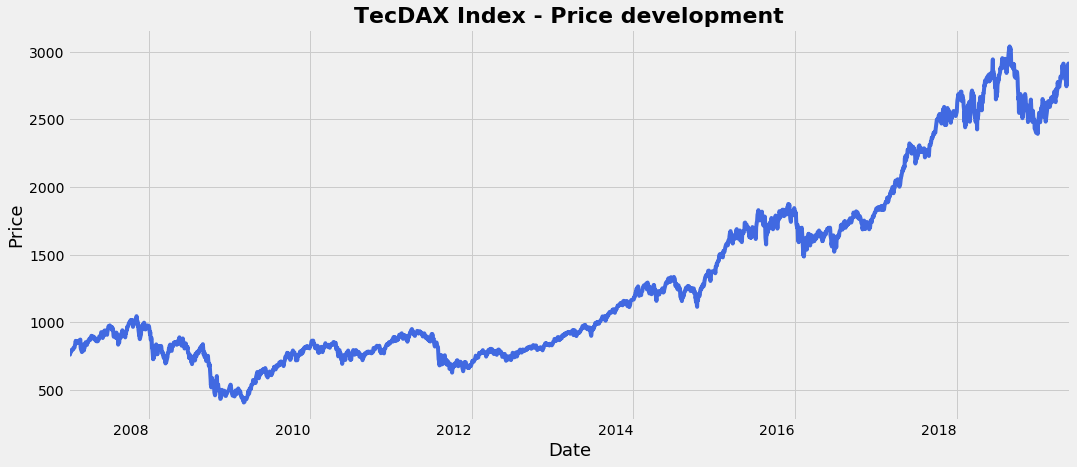

In [4]:
# visualising historical Index price movement
plt.style.use('fivethirtyeight')

TecDAX_close.plot(figsize=(16,8), color="royalblue")
plt.xlabel("Date",fontsize=18,color="black")
plt.ylabel("Price",fontsize=18,color="black")
plt.title("TecDAX Index - Price development",fontweight="bold",fontsize=22)
plt.xticks(rotation=0)

plt.show()

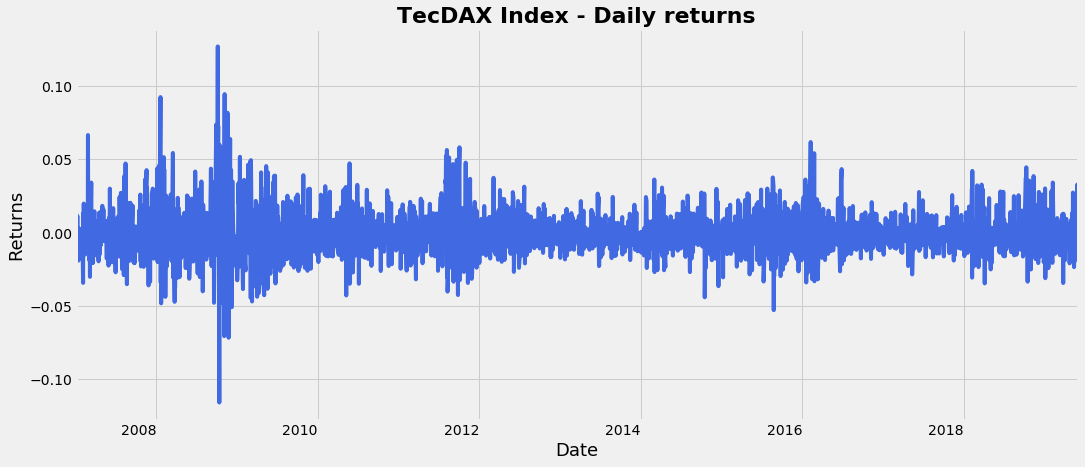

In [5]:
# calculating the daily Index returns
daily_returns = TecDAX_close.shift(1) / TecDAX_close - 1

# visualising the daily Index returns
daily_returns.plot(figsize=(16,8), color="royalblue")
plt.xlabel("Date",fontsize=18,color="black")
plt.ylabel("Returns",fontsize=18,color="black")
plt.title("TecDAX Index - Daily returns", fontweight="bold",fontsize=22)
plt.xticks(rotation=0)

plt.show()

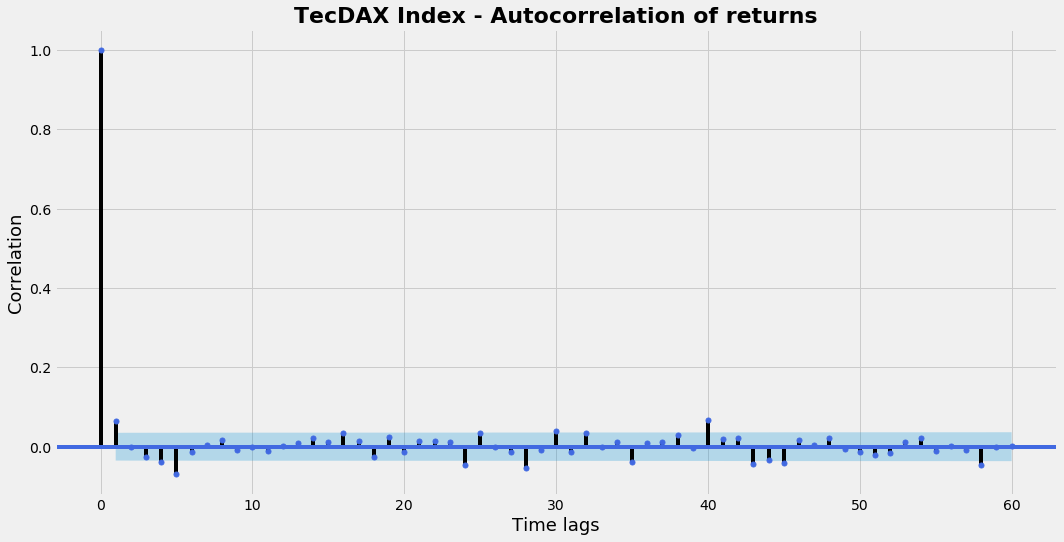

In [6]:
#visualising the autocorrelation of Index returns
plt.rcParams["figure.figsize"] = (16,8)
plot_acf(daily_returns[1:], lags=60, color="royalblue")
plt.title("TecDAX Index - Autocorrelation of returns", fontweight="bold",fontsize=22)
plt.xlabel("Time lags",fontsize=18,color="black")
plt.ylabel("Correlation",fontsize=18,color="black")

plt.show()

---
## 2. Replication 
---

In [7]:
# importing and indexing stock and index data
TecDAX_stocks = pd.read_csv("Alltogether.csv", encoding='latin-1') 
TecDAX_stocks["Date"] = pd.to_datetime(TecDAX_stocks["Date"])
TecDAX_stocks.set_index("Date", inplace=True)  

# separating TecDAX Index data from stock data
y = TecDAX_stocks["TecDAX"]
y = y.values.reshape(len(y),1)
x = TecDAX_stocks.iloc [0:,1:]
x = x.values.reshape(len(y),41)

# defining prediction horizon
test_size = 27
train_size  = len(y) - test_size

# splitting the data into training and test set
y_train, y_test = y[0:train_size], y[train_size:len(y)]
x_train, x_test = x[0:train_size,:], x[train_size:len(y),:]


# extracting validation set from training set
train_size2  = int(train_size * 0.7)

# creating buffer-variable to combine TecDAX data with underlying stock data
buff = np.append(y_train, x_train, axis =1)

# randomizing sample and splitting TecDAX data from stock data again
np.random.shuffle(buff)
y_buff = buff[:,0]
x_buff = buff[:,1:]
np.reshape(x_buff, (len(x_buff),41))
np.reshape(y_buff, (len(x_buff),1))

# rearranging original Data
y_train, y_valid = y_buff[0:train_size2], y_buff[train_size2:train_size]
x_train, x_valid = x_buff[0:train_size2,:], x_buff[train_size2:train_size,:]

In [8]:
# building the neural network
def index_model():
    model = Sequential()
    
    # input layer
    model.add(Dense(1,activation='linear',input_dim=x_train.shape[1])) #the activation function can be linear, since the network consists of only 1 neuron
    
    # output layer
    model.add(Dense(1)) # Scalar Regression -> No Actication Function
    
    # compiling the model, defining optimizer and loss function
    model.compile(optimizer='Adam',loss='mean_absolute_error') #We implemented the best choices of both in this code
    return model

In [9]:
#  !! fitting the model can take significant amount of time and computation power !!

model = index_model()

# traininging the neural network, including validation set to check if overfitting occurs
history = model.fit(x_train, y_train, epochs=2000, validation_data=(x_valid, y_valid))

# getting the performance by using the validaiton set 
Error = model.evaluate(x_train, y_train)
print("Error for the test set: ", Error)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 675 samples, validate on 290 samples
Epoch 1/1000
675/675 [==============================] - 0s 316us/step - loss: 2111.6100 - val_loss: 2082.2982
Epoch 2/1000
675/675 [==============================] - 0s 47us/step - loss: 2081.6008 - val_loss: 2051.6080
Epoch 3/1000
675/675 [==============================] - 0s 52us/step - loss: 2049.9212 - val_loss: 2018.8219
Epoch 4/1000
675/675 [==============================] - 0s 50us/step - loss: 2015.8040 - val_loss: 1983.7413
Epoch 5/1000
675/675 [==============================] - 0s 49us/step - loss: 1979.3512 - val_loss: 1946.2287
Epoch 6/1000
675/675 [==============================] - 0s 48us/step - loss: 1940.0438 - val_loss: 1905.9342
Epoch 7/1000
675/675 [==============================] - 0s 49us/step - loss: 1898.3800 - val_loss: 1863.1827
Epoch 8/1000
675/675 [==============================] - 0s 47us/step - loss: 1854.1297 - val_loss: 1817.6889
Epoch 9/1000
675/675 [==============================] - 0s 49us/step - loss: 1806

Epoch 77/1000
675/675 [==============================] - 0s 46us/step - loss: 25.4329 - val_loss: 23.0696
Epoch 78/1000
675/675 [==============================] - 0s 48us/step - loss: 25.2609 - val_loss: 22.9858
Epoch 79/1000
675/675 [==============================] - 0s 48us/step - loss: 25.2061 - val_loss: 23.1616
Epoch 80/1000
675/675 [==============================] - 0s 48us/step - loss: 24.9626 - val_loss: 22.7580
Epoch 81/1000
675/675 [==============================] - 0s 46us/step - loss: 24.9136 - val_loss: 22.7169
Epoch 82/1000
675/675 [==============================] - 0s 49us/step - loss: 24.7582 - val_loss: 22.6176
Epoch 83/1000
675/675 [==============================] - 0s 48us/step - loss: 24.6475 - val_loss: 22.3129
Epoch 84/1000
675/675 [==============================] - 0s 51us/step - loss: 24.4846 - val_loss: 22.4688
Epoch 85/1000
675/675 [==============================] - 0s 48us/step - loss: 24.5655 - val_loss: 22.2054
Epoch 86/1000
675/675 [=======================

Epoch 154/1000
675/675 [==============================] - 0s 49us/step - loss: 18.3469 - val_loss: 17.3234
Epoch 155/1000
675/675 [==============================] - 0s 47us/step - loss: 18.5701 - val_loss: 18.2641
Epoch 156/1000
675/675 [==============================] - 0s 46us/step - loss: 18.3817 - val_loss: 17.2036
Epoch 157/1000
675/675 [==============================] - 0s 48us/step - loss: 18.2720 - val_loss: 17.2182
Epoch 158/1000
675/675 [==============================] - 0s 50us/step - loss: 18.5736 - val_loss: 17.1832
Epoch 159/1000
675/675 [==============================] - 0s 50us/step - loss: 18.3864 - val_loss: 17.0974
Epoch 160/1000
675/675 [==============================] - 0s 47us/step - loss: 18.1510 - val_loss: 17.1892
Epoch 161/1000
675/675 [==============================] - 0s 47us/step - loss: 18.1978 - val_loss: 17.0812
Epoch 162/1000
675/675 [==============================] - 0s 48us/step - loss: 18.5086 - val_loss: 16.9235
Epoch 163/1000
675/675 [=============

675/675 [==============================] - 0s 46us/step - loss: 14.9189 - val_loss: 14.4097
Epoch 231/1000
675/675 [==============================] - 0s 50us/step - loss: 15.0816 - val_loss: 14.5600
Epoch 232/1000
675/675 [==============================] - 0s 48us/step - loss: 15.3472 - val_loss: 14.5213
Epoch 233/1000
675/675 [==============================] - 0s 47us/step - loss: 15.3044 - val_loss: 14.2276
Epoch 234/1000
675/675 [==============================] - 0s 48us/step - loss: 14.9646 - val_loss: 14.2538
Epoch 235/1000
675/675 [==============================] - 0s 50us/step - loss: 14.7324 - val_loss: 14.2303
Epoch 236/1000
675/675 [==============================] - 0s 47us/step - loss: 14.7212 - val_loss: 14.2753
Epoch 237/1000
675/675 [==============================] - 0s 47us/step - loss: 14.6282 - val_loss: 15.2132
Epoch 238/1000
675/675 [==============================] - 0s 48us/step - loss: 15.2853 - val_loss: 14.1678
Epoch 239/1000
675/675 [============================

675/675 [==============================] - 0s 48us/step - loss: 13.6828 - val_loss: 12.8287
Epoch 307/1000
675/675 [==============================] - 0s 49us/step - loss: 12.8678 - val_loss: 13.2256
Epoch 308/1000
675/675 [==============================] - 0s 49us/step - loss: 13.3688 - val_loss: 13.2811
Epoch 309/1000
675/675 [==============================] - 0s 50us/step - loss: 13.0552 - val_loss: 12.8925
Epoch 310/1000
675/675 [==============================] - 0s 47us/step - loss: 12.9757 - val_loss: 12.6982
Epoch 311/1000
675/675 [==============================] - 0s 47us/step - loss: 12.8554 - val_loss: 13.7047
Epoch 312/1000
675/675 [==============================] - 0s 48us/step - loss: 13.1832 - val_loss: 13.1756
Epoch 313/1000
675/675 [==============================] - 0s 46us/step - loss: 13.0355 - val_loss: 12.6425
Epoch 314/1000
675/675 [==============================] - 0s 46us/step - loss: 13.0814 - val_loss: 12.5756
Epoch 315/1000
675/675 [============================

675/675 [==============================] - 0s 46us/step - loss: 11.7225 - val_loss: 11.5130
Epoch 383/1000
675/675 [==============================] - 0s 47us/step - loss: 11.7341 - val_loss: 11.6565
Epoch 384/1000
675/675 [==============================] - 0s 50us/step - loss: 11.9283 - val_loss: 11.5049
Epoch 385/1000
675/675 [==============================] - 0s 47us/step - loss: 11.7357 - val_loss: 11.5786
Epoch 386/1000
675/675 [==============================] - 0s 50us/step - loss: 11.7179 - val_loss: 11.4774
Epoch 387/1000
675/675 [==============================] - 0s 48us/step - loss: 11.9101 - val_loss: 11.4620
Epoch 388/1000
675/675 [==============================] - 0s 50us/step - loss: 11.6328 - val_loss: 11.6487
Epoch 389/1000
675/675 [==============================] - 0s 49us/step - loss: 11.7151 - val_loss: 11.9452
Epoch 390/1000
675/675 [==============================] - 0s 47us/step - loss: 11.8090 - val_loss: 11.5712
Epoch 391/1000
675/675 [============================

675/675 [==============================] - 0s 48us/step - loss: 11.2589 - val_loss: 10.9637
Epoch 459/1000
675/675 [==============================] - 0s 48us/step - loss: 10.8608 - val_loss: 10.6271
Epoch 460/1000
675/675 [==============================] - 0s 49us/step - loss: 10.9243 - val_loss: 10.6040
Epoch 461/1000
675/675 [==============================] - 0s 47us/step - loss: 10.9743 - val_loss: 10.6252
Epoch 462/1000
675/675 [==============================] - 0s 48us/step - loss: 10.9650 - val_loss: 10.5869
Epoch 463/1000
675/675 [==============================] - 0s 47us/step - loss: 10.8981 - val_loss: 10.5516
Epoch 464/1000
675/675 [==============================] - 0s 47us/step - loss: 10.8230 - val_loss: 10.6436
Epoch 465/1000
675/675 [==============================] - 0s 48us/step - loss: 10.8486 - val_loss: 11.2145
Epoch 466/1000
675/675 [==============================] - 0s 47us/step - loss: 11.1385 - val_loss: 10.6152
Epoch 467/1000
675/675 [============================

675/675 [==============================] - 0s 47us/step - loss: 10.3193 - val_loss: 9.9063
Epoch 535/1000
675/675 [==============================] - 0s 54us/step - loss: 10.2883 - val_loss: 10.0361
Epoch 536/1000
675/675 [==============================] - 0s 48us/step - loss: 10.2848 - val_loss: 9.8931
Epoch 537/1000
675/675 [==============================] - 0s 49us/step - loss: 10.3770 - val_loss: 10.3220
Epoch 538/1000
675/675 [==============================] - 0s 46us/step - loss: 10.2727 - val_loss: 10.0018
Epoch 539/1000
675/675 [==============================] - 0s 49us/step - loss: 10.4371 - val_loss: 9.9539
Epoch 540/1000
675/675 [==============================] - 0s 47us/step - loss: 10.3661 - val_loss: 10.1831
Epoch 541/1000
675/675 [==============================] - 0s 45us/step - loss: 10.3553 - val_loss: 10.0339
Epoch 542/1000
675/675 [==============================] - 0s 48us/step - loss: 10.1653 - val_loss: 9.8700
Epoch 543/1000
675/675 [==============================] 

675/675 [==============================] - 0s 46us/step - loss: 9.9029 - val_loss: 9.4221
Epoch 612/1000
675/675 [==============================] - 0s 45us/step - loss: 9.6754 - val_loss: 9.3783
Epoch 613/1000
675/675 [==============================] - 0s 50us/step - loss: 9.6909 - val_loss: 9.5167
Epoch 614/1000
675/675 [==============================] - 0s 51us/step - loss: 10.0798 - val_loss: 9.3259
Epoch 615/1000
675/675 [==============================] - 0s 48us/step - loss: 10.0597 - val_loss: 9.7723
Epoch 616/1000
675/675 [==============================] - 0s 48us/step - loss: 9.7640 - val_loss: 9.6241
Epoch 617/1000
675/675 [==============================] - 0s 47us/step - loss: 9.8812 - val_loss: 9.3738
Epoch 618/1000
675/675 [==============================] - 0s 47us/step - loss: 9.8759 - val_loss: 9.3872
Epoch 619/1000
675/675 [==============================] - 0s 49us/step - loss: 9.7018 - val_loss: 9.3526
Epoch 620/1000
675/675 [==============================] - 0s 47us/st

675/675 [==============================] - 0s 48us/step - loss: 9.3405 - val_loss: 8.8901
Epoch 690/1000
675/675 [==============================] - 0s 49us/step - loss: 9.4097 - val_loss: 8.9920
Epoch 691/1000
675/675 [==============================] - 0s 52us/step - loss: 9.3418 - val_loss: 9.0279
Epoch 692/1000
675/675 [==============================] - 0s 50us/step - loss: 9.2943 - val_loss: 9.8315
Epoch 693/1000
675/675 [==============================] - 0s 51us/step - loss: 10.0024 - val_loss: 9.2089
Epoch 694/1000
675/675 [==============================] - 0s 50us/step - loss: 9.3638 - val_loss: 9.1431
Epoch 695/1000
675/675 [==============================] - 0s 49us/step - loss: 9.2747 - val_loss: 9.0800
Epoch 696/1000
675/675 [==============================] - 0s 50us/step - loss: 9.3718 - val_loss: 9.1632
Epoch 697/1000
675/675 [==============================] - 0s 49us/step - loss: 9.4351 - val_loss: 9.0853
Epoch 698/1000
675/675 [==============================] - 0s 52us/ste

675/675 [==============================] - 0s 47us/step - loss: 8.9037 - val_loss: 8.4372
Epoch 768/1000
675/675 [==============================] - 0s 49us/step - loss: 8.8445 - val_loss: 8.6206
Epoch 769/1000
675/675 [==============================] - 0s 49us/step - loss: 8.9162 - val_loss: 8.5837
Epoch 770/1000
675/675 [==============================] - 0s 48us/step - loss: 8.9210 - val_loss: 8.4820
Epoch 771/1000
675/675 [==============================] - 0s 49us/step - loss: 8.9448 - val_loss: 8.7763
Epoch 772/1000
675/675 [==============================] - 0s 47us/step - loss: 9.2543 - val_loss: 8.4470
Epoch 773/1000
675/675 [==============================] - 0s 48us/step - loss: 9.0753 - val_loss: 8.5598
Epoch 774/1000
675/675 [==============================] - 0s 48us/step - loss: 9.0805 - val_loss: 8.7846
Epoch 775/1000
675/675 [==============================] - 0s 49us/step - loss: 9.1025 - val_loss: 8.5637
Epoch 776/1000
675/675 [==============================] - 0s 50us/step

675/675 [==============================] - 0s 47us/step - loss: 8.9224 - val_loss: 8.4541
Epoch 846/1000
675/675 [==============================] - 0s 46us/step - loss: 8.6267 - val_loss: 8.2081
Epoch 847/1000
675/675 [==============================] - 0s 47us/step - loss: 8.6510 - val_loss: 8.4260
Epoch 848/1000
675/675 [==============================] - 0s 47us/step - loss: 8.7427 - val_loss: 8.0824
Epoch 849/1000
675/675 [==============================] - 0s 47us/step - loss: 8.6040 - val_loss: 8.4072
Epoch 850/1000
675/675 [==============================] - 0s 48us/step - loss: 8.6830 - val_loss: 8.4927
Epoch 851/1000
675/675 [==============================] - 0s 46us/step - loss: 8.7055 - val_loss: 8.2307
Epoch 852/1000
675/675 [==============================] - 0s 48us/step - loss: 8.6432 - val_loss: 8.0992
Epoch 853/1000
675/675 [==============================] - 0s 45us/step - loss: 8.6008 - val_loss: 8.0554
Epoch 854/1000
675/675 [==============================] - 0s 50us/step

675/675 [==============================] - 0s 46us/step - loss: 8.3879 - val_loss: 8.2706
Epoch 924/1000
675/675 [==============================] - 0s 48us/step - loss: 8.3139 - val_loss: 8.0885
Epoch 925/1000
675/675 [==============================] - 0s 48us/step - loss: 8.4113 - val_loss: 8.0389
Epoch 926/1000
675/675 [==============================] - 0s 49us/step - loss: 8.2770 - val_loss: 7.8349
Epoch 927/1000
675/675 [==============================] - 0s 48us/step - loss: 8.2922 - val_loss: 8.2166
Epoch 928/1000
675/675 [==============================] - 0s 46us/step - loss: 8.1909 - val_loss: 7.8546
Epoch 929/1000
675/675 [==============================] - 0s 49us/step - loss: 8.3078 - val_loss: 7.9833
Epoch 930/1000
675/675 [==============================] - 0s 49us/step - loss: 8.2292 - val_loss: 7.8305
Epoch 931/1000
675/675 [==============================] - 0s 51us/step - loss: 8.2627 - val_loss: 7.8136
Epoch 932/1000
675/675 [==============================] - 0s 48us/step

675/675 [==============================] - 0s 16us/step
Error for the test set:  7.9473974623503505


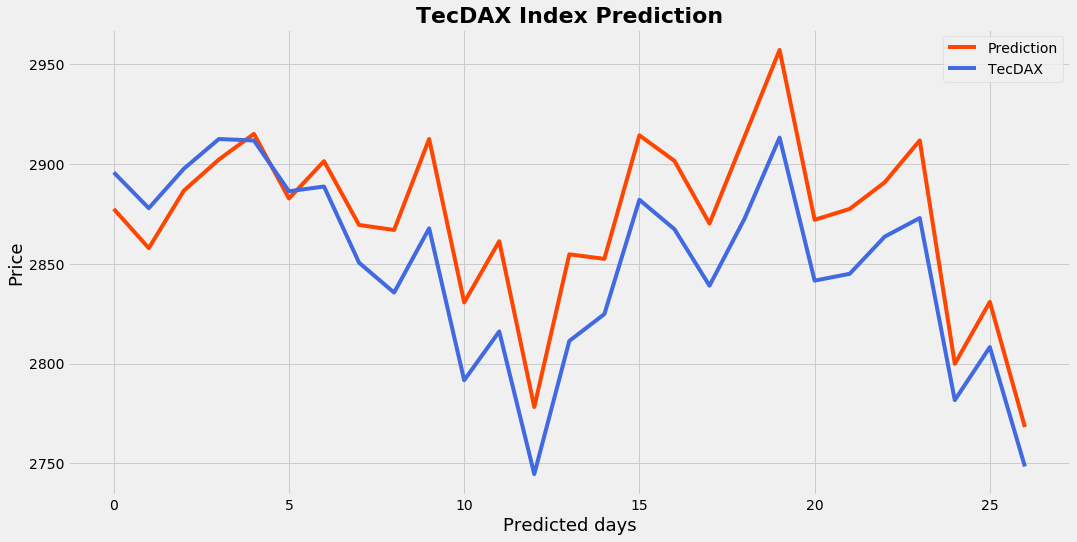

In [10]:
# plotting predicted Index prices against realised Index prices
predicted_level = model.predict(x_test)
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(predicted_level, color = 'orangered', label = 'Prediction')
plt.plot(y_test[0:,], color = 'royalblue', label = 'TecDAX')
plt.title('TecDAX Index Prediction', fontweight='bold',fontsize=22)
plt.xlabel('Predicted days',fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.legend()

plt.show()

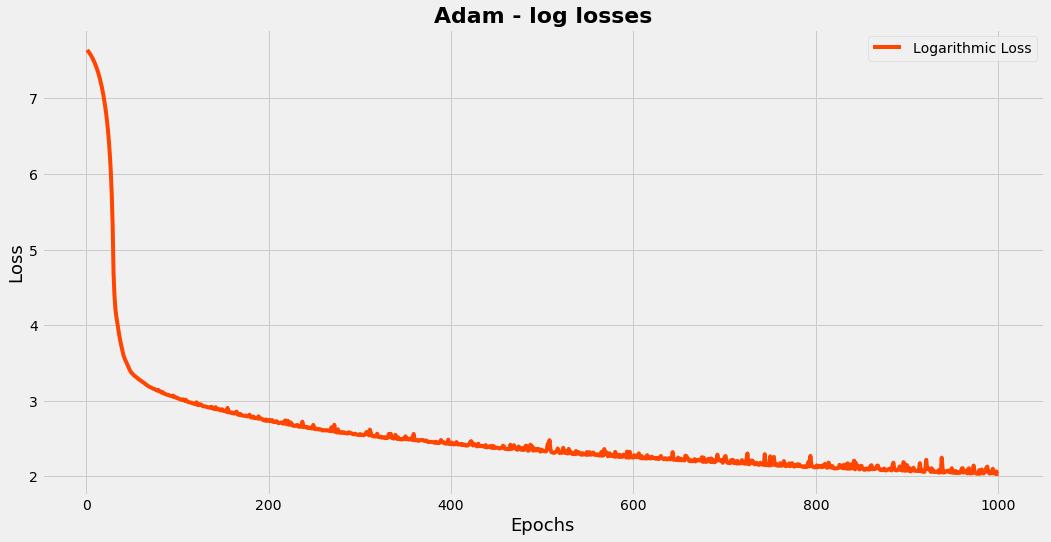

In [11]:
# visualising overfitting
history_dict = history.history
history_dict.keys()
loss_values = np.log(history_dict['val_loss'])
acc = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(epochs, loss_values, color = 'orangered', label = 'Logarithmic Loss')
plt.title('Adam - log losses', fontweight='bold',fontsize=22)
plt.xlabel('Epochs',fontsize=18,color='black')
plt.ylabel('Loss',fontsize=18,color='black')
plt.legend()

plt.show()

---
# 3. Additive Model Forecasting
---

Forecasting in the scope of this report is the attempt to predict how future prices will develop. We can distinguish between two major approaches in this matter, namely explanatory and time-series forcasting. While exploratory approaches aim to extract cause and effect relationships between input factors and output factors, time-series forcasting does not concentrate on understanding these relationships reather than finding patterns in past price realisations. There are two reasons for undertaking time-series forcasting. First, the system is too complex to be completely understood or the relationships that affect the output are to difficult to measure. Second, the main concern is not to understand why the output develops in a certain way but how it developes.

Not all forecasting problems can be solved by the same procedure. Prophet is optimized for business forecasting tasks, which have the following characteristics: hourly, daily, or weekly observations with at least a few months (preferably multiple years) of history. At its core, the Prophet procedure is an additive regression model with three main components:

 - A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
 - A yearly seasonal component modeled using Fourier series.
 - A weekly seasonal component using dummy variables.
 
We use the TecDAX Index dataset to train the Prophet Model. However we split the observations of the year 2018 and the first half of 2019 into a test set. After training the Prophet Model we predict 1,5 years of the Index Price and compare it to the realised observations in the test set. The prediction results will be shown as a solid blue line with an 80% confidence intervall(light blue area). In orange color we represent the true Index price realised during the year 2018 and the first half of 2019.

One of the biggest upsides of the Prophet model is that it does not only predict a possible realisation of a  price at a certain time in the future but also predicts the prices with a 80% confidence intervall. In the context of Stock or Index price relisations, confidence intervalls are an essential feature of forcasting models, since future price realisations are highly uncertain no matter how good the model is. 
 

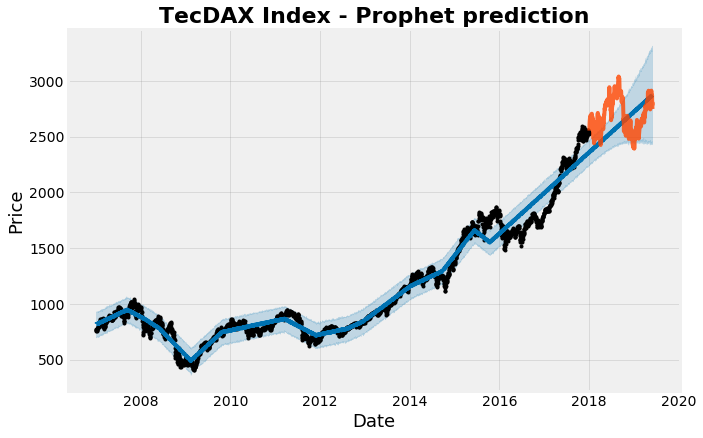

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,self_define_cycle,self_define_cycle_lower,self_define_cycle_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3297,2019-05-24,2866.524379,2430.879302,3267.156600,2447.469608,3280.242812,-1.943778,-1.943778,-1.943778,-1.943778,-1.943778,-1.943778,0.0,0.0,0.0,2864.580601
3298,2019-05-25,2867.520741,2440.703646,3304.232405,2446.258273,3282.319171,-2.194547,-2.194547,-2.194547,-2.194547,-2.194547,-2.194547,0.0,0.0,0.0,2865.326194
3299,2019-05-26,2868.517103,2459.764224,3292.742229,2445.046937,3284.822787,-3.054872,-3.054872,-3.054872,-3.054872,-3.054872,-3.054872,0.0,0.0,0.0,2865.462231
3300,2019-05-27,2869.513465,2445.431187,3271.141105,2443.835602,3287.326403,-3.828502,-3.828502,-3.828502,-3.828502,-3.828502,-3.828502,0.0,0.0,0.0,2865.684963
3301,2019-05-28,2870.509827,2438.044424,3317.767287,2442.624266,3289.830019,-1.224318,-1.224318,-1.224318,-1.224318,-1.224318,-1.224318,0.0,0.0,0.0,2869.285509


In [13]:
#  !! fitting the model can take significant amount of time and computation power !!

# setting up the model specifications
def cycle_analysis(data,split_date,cycle,mode='additive',forecast_plot = False,print_ind=False):
    
    # splitting the data in training and test set
    training = data[:split_date].iloc[:-1,]
    testing = data[split_date:]
    
    # defining the period to predict
    predict_period = len(pd.date_range(split_date,max(data.index)))
    df = training.reset_index()
    df.columns = ['ds','y']
    
    # exchanging default seasionality with self defined cycle
    model = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
    model.add_seasonality('self_define_cycle',period=cycle,fourier_order=8,mode=mode)
    
    # fitting the model
    model.fit(df)
    future = model.make_future_dataframe(periods=predict_period)
    forecast = model.predict(future)
   
    # visualising the results
    if forecast_plot:
        model.plot(forecast)
        plt.plot(testing.index,testing.values,color='orangered',alpha=0.8)
        plt.title("TecDAX Index - Prophet prediction",fontweight='bold',fontsize=22)
        plt.xlabel('Date',fontsize=18,color='black')
        plt.ylabel('Price',fontsize=18,color='black')
        plt.show()
    ret = max(forecast.self_define_cycle)-min(forecast.self_define_cycle)
    model_tb = forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x:x.strftime("%Y-%m-%d"))
    
    #show model results (last 5 predictions)
    return forecast.tail()
      
# deploying the model to the TecDAX Index data
cycle_analysis(TecDAX_close,'2018-01-02',30,forecast_plot=True,print_ind=True)

---
# 4. Recurrent Neural Network Forecasting
---


In [15]:
# reshaping
TecDAX_close = TecDAX_close.values.reshape(len(TecDAX),1)

# spliting the data into training and test set
train_size = int(len(TecDAX_close) * 0.993)
test_size  = len(TecDAX_close) - train_size
TecDAX_train, TecDAX_test = TecDAX_close[0:train_size,:], TecDAX_close[train_size:len(TecDAX),:]

print("Training observations: ", len(TecDAX_train))
print("Testing observations:  ", len(TecDAX_test))

Training observations:  3120
Testing observations:   23


In [16]:
# normalizing the data
sc = MinMaxScaler(feature_range = (0, 1))

TecDAX_train.shape
training_set_scaled = sc.fit_transform(TecDAX_train)
test_set_scaled     = sc.fit_transform(TecDAX_test)

In [17]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [18]:
# !! fitting the model can take significant amount of time and computation power !!

# initialising the RNN
regressor = Sequential()

# adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units = 1))

# compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/50
1198/1198 [==============================] - 13s 11ms/step - loss: 0.0027
Epoch 2/50
1198/1198 [==============================] - 10s 8ms/step - loss: 6.4722e-04
Epoch 3/50
1198/1198 [==============================] - 10s 8ms/step - loss: 4.9759e-04
Epoch 4/50
1198/1198 [==============================] - 10s 8ms/step - loss: 4.9086e-04
Epoch 5/50
1198/1198 [==============================] - 10s 8ms/step - loss: 4.1812e-04
Epoch 6/50
1198/1198 [==============================] - 10s 8ms/step - loss: 4.3236e-04
Epoch 7/50
1198/1198 [==============================] - 10s 8ms/step - loss: 3.6458e-04
Epoch 8/50
1198/1198 [==============================] - 10s 8ms/step - loss: 3.3935e-04
Epoch 9/50
1198/1198 [==============================] - 10s 8ms/step - loss: 3.6475e-04
Epoch 10/50
1198/1198 [==============================] - 10s 8ms/step - loss: 3.0995e-04
Epoch 11/50
1198/1198 [==============================] - 10s 8ms/step - loss: 2.9824e-04
Epoch 12/50
1198/1198 [==========

In [19]:
# getting the predicted stock price
dataset_total = pd.concat((pd.Series(TecDAX_train[:,0]), pd.Series(TecDAX_test[:,0])), axis = 0)
inputs = dataset_total[len(dataset_total) - len(TecDAX_test) - 60:]
inputs = inputs.values.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

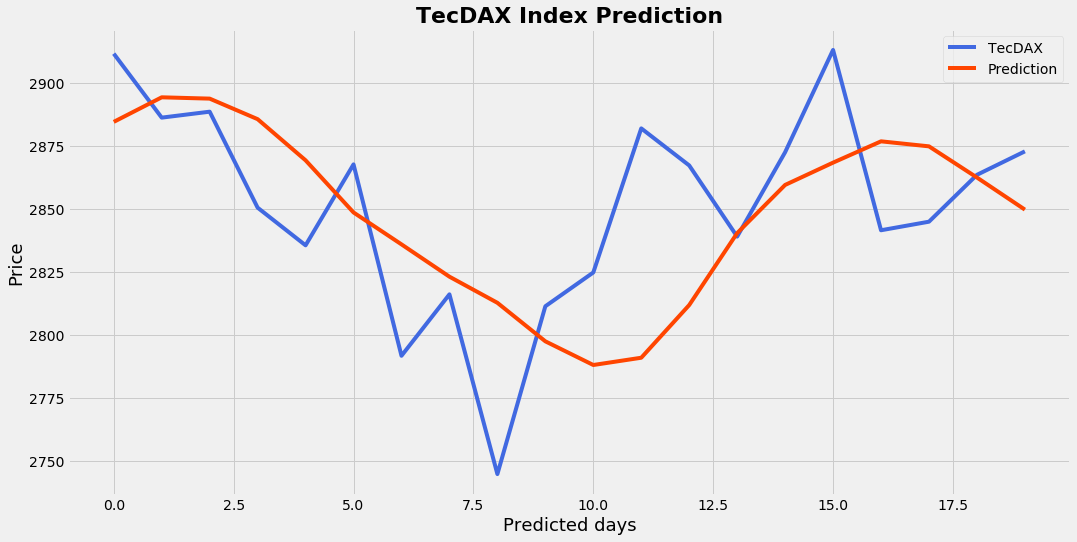

In [20]:
# Visualising the results
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(TecDAX_test[0:20,:], color = 'royalblue', label = 'TecDAX')
plt.plot(predicted_stock_price, color = 'orangered', label = 'Prediction')
plt.title('TecDAX Index Prediction', fontweight='bold',fontsize=22)
plt.xlabel('Predicted days',fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.legend()

plt.show()

---
**End of Report**. All datasets and code can be found in our GitHub repository:
